In [1]:
from bs4 import BeautifulSoup
import urllib.request
import re

url="http://www.leagueofgraphs.com/champions/stats/diamond"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page.read(), "lxml")



In [2]:
for tr in soup.find_all('tr')[1:145]:
    tds = tr.find_all('td')
    
    if len(tds) >1:
        name = tds[1].text.split()
    
        champ_name = name[0].lower().replace("'", '').replace(",", '').replace(".", '')
        if champ_name == 'lee':
            champ_name = 'leesin'
        elif champ_name == 'miss':
            champ_name = 'missfortune'
        elif champ_name == 'twisted':
            champ_name = 'twistedfate'
        elif champ_name == 'master':
            champ_name = 'masteryi'
        elif champ_name == 'xin':
            champ_name = 'xinzhao'
        elif champ_name == 'dr':
            champ_name = 'drmundo'
        elif champ_name == 'tahm':
            champ_name = 'tahmkench'
        elif champ_name == 'aurelion':
            champ_name = 'aurelionsol'              
        elif champ_name == 'jarvan':
            champ_name = 'jarvaniv' 
            
        pop = float(tds[2].text.split()[0][0:-1])
        winrate = tds[3].text.split()[0][0:-1]
        banrate = tds[4].text.split()[0][0:-1]
        
#         print(champ_name, str(pop), str(winrate), str(banrate))
        
        with open('lolcurrent_raw_20170201.csv', 'a') as f:
            s = champ_name + ',' + str(pop) + ',' +  str(winrate) + ',' + \
                str(banrate) + '\n'
            f.write(s)

In [82]:
import pandas as pd
from datetime import datetime
import time

df = pd.read_csv('lolcurrent_raw_20170201.csv', names = ['name', 'popularity', 'winrate',
                                           'banrate'])
df_release = pd.read_csv('lolrelease.csv', names=['name', 'release'])

In [83]:
df = df.merge(df_release, how='outer', on='name')

In [84]:
df.dropna(inplace=True, axis=0)

In [85]:
df.head()

,name,popularity,winrate,banrate,release
0,jhin,37.5,51.9,0.7,1.451606e+09
1,leesin,35.7,48.4,8.6,1.270080e+09
2,ezreal,31.1,47.5,0.2,1.267402e+09
3,thresh,29.7,48.7,0.4,1.356998e+09
4,khazix,27.3,54.2,47.3,1.346458e+09


In [86]:

date = datetime.now()
date = time.mktime(date.timetuple())

df['tsr'] = df.apply(lambda x: date-x.release, axis=1)

In [87]:
df.head()

,name,popularity,winrate,banrate,release,tsr
0,jhin,37.5,51.9,0.7,1.451606e+09,34468975.0
1,leesin,35.7,48.4,8.6,1.270080e+09,215995375.0
2,ezreal,31.1,47.5,0.2,1.267402e+09,218673775.0
3,thresh,29.7,48.7,0.4,1.356998e+09,129076975.0
4,khazix,27.3,54.2,47.3,1.346458e+09,139617775.0


In [ ]:
# df_release = pd.read_csv('lolcurrent.csv', names=['name', 'release'])

In [13]:
# df.to_csv('lolcurrent.csv', index=False)

In [88]:
df_all = pd.read_csv('loldata_cleaned_v2.csv')
df_all.head()

,banrate,changes,date,freq_buff,freq_nerf,haschange,name,popularity,release,ts_buff,ts_nerf,tsr,vbr,vpop,vwr,winrate
0,0.13,nochange,1.395140e+09,5.0,5.0,False,aatrox,4.34,1.370045e+09,25.0,25.0,2.509560e+07,-0.31,-0.04,-2.02,49.72
1,0.19,nochange,1.395767e+09,21.0,16.0,False,aatrox,4.80,1.370045e+09,25.0,25.0,2.572200e+07,0.06,0.46,1.13,50.85
2,0.28,nochange,1.396411e+09,18.0,14.0,False,aatrox,5.06,1.370045e+09,25.0,25.0,2.636640e+07,0.09,0.26,0.03,50.88
3,0.20,nochange,1.397171e+09,14.0,18.0,False,aatrox,4.53,1.370045e+09,25.0,25.0,2.712601e+07,-0.08,-0.53,-1.40,49.48
4,0.34,nochange,1.397808e+09,14.0,16.0,False,aatrox,4.53,1.370045e+09,25.0,25.0,2.776320e+07,0.14,0.00,1.71,51.19


In [89]:
lastall = df_all[df_all['date']==df_all['date'].max()][['name', 'ts_buff', 'ts_nerf', 'popularity', 'winrate','banrate']]
lastall.head(10)

,name,ts_buff,ts_nerf,popularity,winrate,banrate
129,aatrox,25.0,25.0,0.82,46.38,0.77
259,ryze,6.0,24.0,11.67,45.78,18.69
388,sejuani,25.0,25.0,1.29,46.99,0.03
518,diana,25.0,24.0,2.17,46.85,0.17
648,shaco,25.0,25.0,9.04,52.63,4.02
778,zilean,25.0,25.0,4.92,52.65,0.15
908,shen,23.0,17.0,3.28,46.65,0.04
1038,shyvana,6.0,17.0,2.13,46.42,0.31
1167,darius,25.0,25.0,11.29,52.08,10.93
1296,singed,25.0,21.0,7.10,49.67,1.16


In [90]:
lastall['ts_buff'] = lastall['ts_buff'].apply(lambda x: x+1 if x <25 else 25)
lastall['ts_nerf'] = lastall['ts_nerf'].apply(lambda x: x+1 if x <25 else 25)
lastall.sort_values('name', inplace=True)
lastall.reset_index(inplace=True, drop=True)
lastall.head(10)

,name,ts_buff,ts_nerf,popularity,winrate,banrate
0,aatrox,25.0,25.0,0.82,46.38,0.77
1,ahri,25.0,25.0,14.56,52.30,1.17
2,akali,25.0,16.0,2.22,52.53,0.21
3,alistar,25.0,25.0,5.48,47.70,0.33
4,amumu,25.0,25.0,1.91,46.48,0.15
5,anivia,18.0,25.0,2.82,53.43,0.17
6,annie,25.0,25.0,4.08,50.37,0.32
7,ashe,24.0,25.0,9.26,50.01,0.07
8,aurelionsol,22.0,25.0,1.58,56.27,0.25
9,azir,25.0,16.0,1.75,45.98,0.14


In [91]:
df = df.merge(lastall[['name', 'ts_buff', 'ts_nerf']], on='name')
df.sort_values('name', inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,name,popularity,winrate,banrate,release,tsr,ts_buff,ts_nerf
0,aatrox,0.6,45.8,0.7,1.370045e+09,116030575.0,25.0,25.0
1,ahri,13.9,52.3,1.0,1.322698e+09,163377775.0,25.0,25.0
2,akali,2.6,50.5,0.3,1.272672e+09,213403375.0,25.0,16.0
3,alistar,4.5,48.9,0.2,1.233446e+09,252628975.0,25.0,25.0
4,amumu,1.5,44.5,0.1,1.243814e+09,242260975.0,25.0,25.0


In [92]:
df['vpop'] = df['popularity']-lastall['popularity']
df['vwr'] = df['winrate']-lastall['winrate']
df['vbr'] = df['banrate']-lastall['banrate']

In [93]:
df.head()

,name,popularity,winrate,banrate,release,tsr,ts_buff,ts_nerf,vpop,vwr,vbr
0,aatrox,0.6,45.8,0.7,1.370045e+09,116030575.0,25.0,25.0,-0.22,-0.58,-0.07
1,ahri,13.9,52.3,1.0,1.322698e+09,163377775.0,25.0,25.0,-0.66,0.00,-0.17
2,akali,2.6,50.5,0.3,1.272672e+09,213403375.0,25.0,16.0,0.38,-2.03,0.09
3,alistar,4.5,48.9,0.2,1.233446e+09,252628975.0,25.0,25.0,-0.98,1.20,-0.13
4,amumu,1.5,44.5,0.1,1.243814e+09,242260975.0,25.0,25.0,-0.41,-1.98,-0.05


In [94]:
# df.to_csv('lolcurrent.csv', index=False)

In [146]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.externals import joblib

xgbc = joblib.load('xgbc.dat') 

df = pd.read_csv('lolcurrent.csv')

df.head()
p_xgb_o = xgbc.predict(df[['popularity', 'winrate', 'banrate', 'tsr', 'ts_buff', 'ts_nerf', 'vpop',
       'vbr', 'vwr']].as_matrix())
prob_xgb_o = xgbc.predict_proba(df[['popularity', 'winrate', 'banrate', 'tsr', 'ts_buff', 'ts_nerf', 'vpop',
       'vbr', 'vwr']].as_matrix())

dfp = pd.DataFrame(p_xgb_o, columns=['changes']) 

print(df.iloc[dfp[dfp['changes']=='nerf'].index]['name'])
print(df.iloc[dfp[dfp['changes']=='buff'].index]['name'])


15     camille
44       jayce
54      khazix
58     leblanc
66    malzahar
86      rengar
Name: name, dtype: object
33         gnar
62       lucian
121    vladimir
123     warwick
Name: name, dtype: object


/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


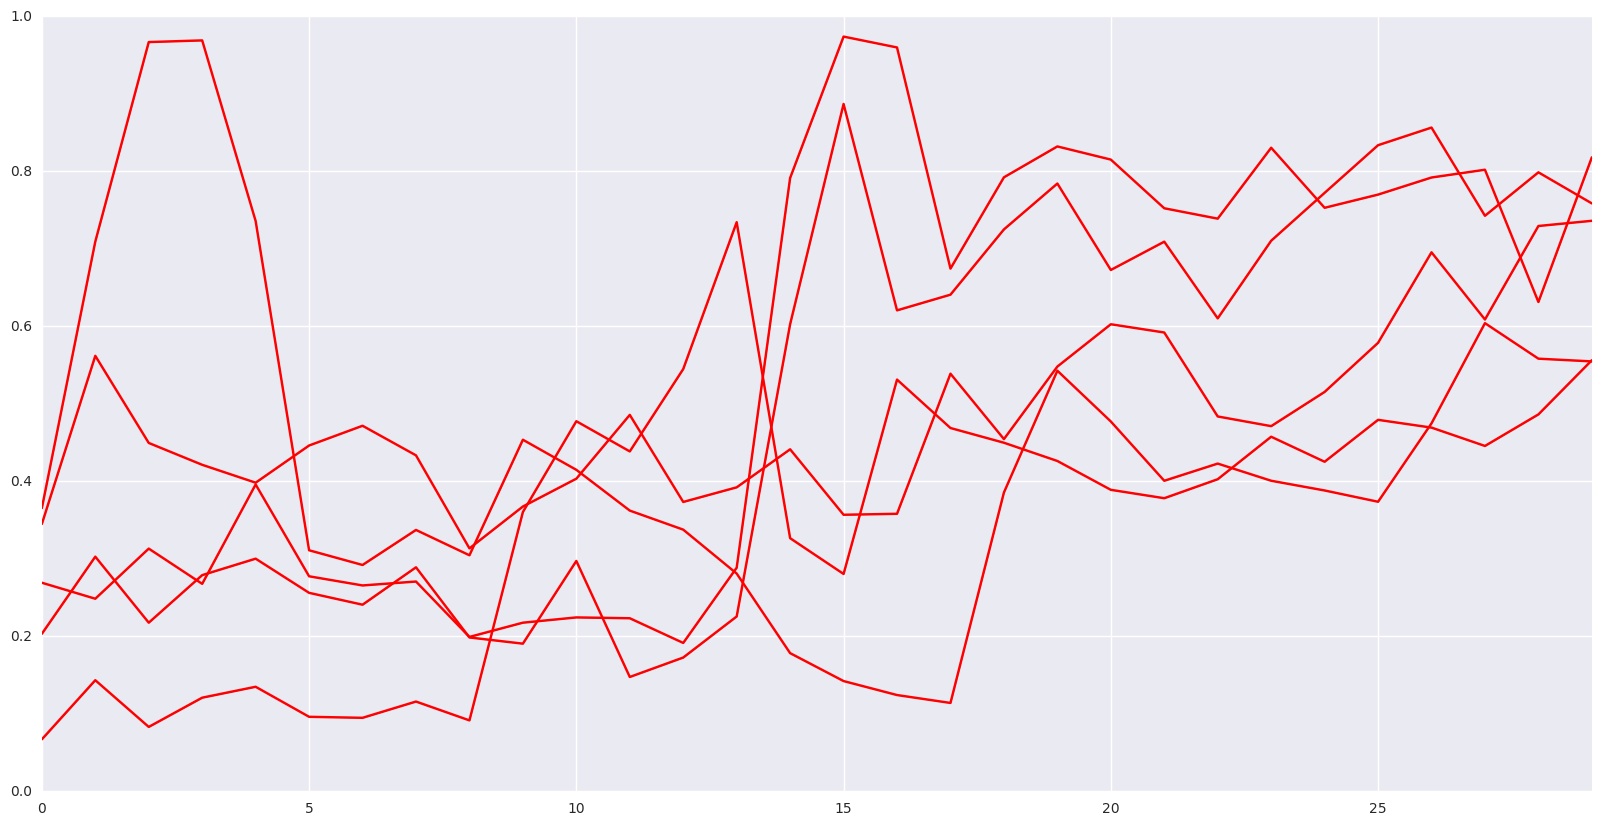

In [207]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df_probs = pd.read_csv('lolcurrent_probs.csv')
plt.figure(figsize=(20,10))
           
for champ in df.iloc[dfp[dfp['changes']=='nerf'].index]['name']:
#     champ = df.iloc[dfp[dfp['changes']=='nerf'].index]['name'].iloc[0]
    data = df_probs[df_probs['name']==champ]['nerf']
    if len(data) > 15:
        ax = sns.tsplot(data=data, color = 'red')
        
plt.legend()

In [212]:
df_probs[df_probs['name']==champ]

,name,buff,nerf,nochange
1020,rengar,0.090984,0.203174,0.705842
1021,rengar,0.145581,0.302725,0.551695
1022,rengar,0.095228,0.217538,0.687234
1023,rengar,0.130844,0.278898,0.590258
1024,rengar,0.137873,0.300143,0.561985
1025,rengar,0.140825,0.256052,0.603124
1026,rengar,0.165013,0.240743,0.594244
1027,rengar,0.089912,0.289000,0.621089
1028,rengar,0.075000,0.198472,0.726527
1029,rengar,0.105124,0.190480,0.704396


In [ ]:
sudo docker run --rm -d --name flask1 -p 80:80 joe/flaskimage:version002

In [ ]:
sudo docker exec -i -t flask1 /bin/bash

In [ ]:
sudo docker stop flask1
sudo docker build -t joe/flaskimage:version002 .

# blue trinket.gg